In [2]:
import numpy
import cv2
import matplotlib.pyplot as plt
import numpy as np

im  = cv2.imread('../DensePoseData/demo_data_2/im.jpg')
IUV = cv2.imread('../DensePoseData/demo_data_2/IUV.png')
INDS = cv2.imread('../DensePoseData/demo_data_2/INDS.png',  0)

Let's visualize the isocontours of the UV fields.

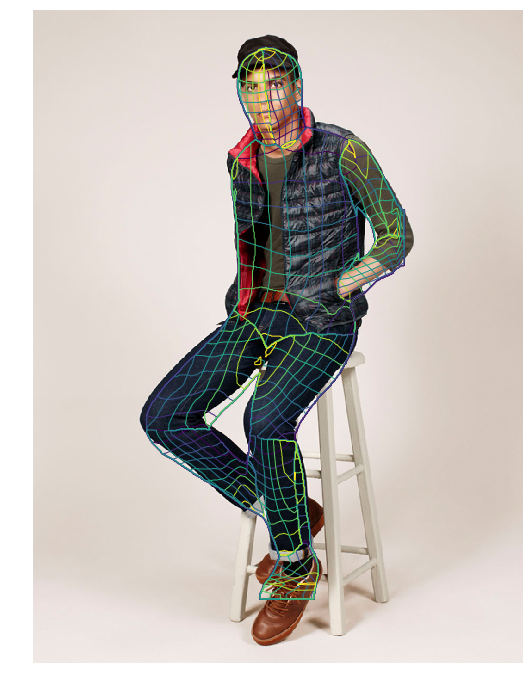

In [4]:
fig = plt.figure(figsize=[12,12])
plt.imshow( im[:,:,::-1] )
plt.contour( IUV[:,:,1]/256.,10, linewidths = 1 )
plt.contour( IUV[:,:,2]/256.,10, linewidths = 1 )
plt.axis('off') ; plt.show()

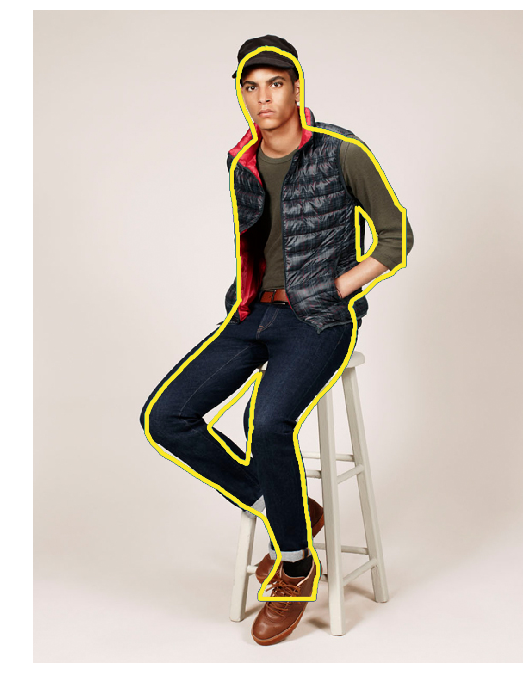

In [5]:
fig = plt.figure(figsize=[12,12])
plt.imshow( im[:,:,::-1] )
plt.contour( INDS, linewidths = 4 )
plt.axis('off') ; plt.show()

Let's visualize the I, U and V images.

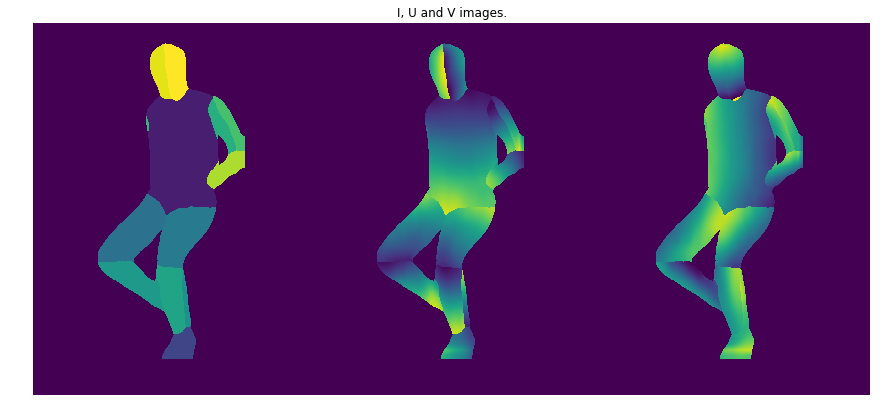

In [15]:
fig = plt.figure(figsize=[15,15])
plt.imshow(   np.hstack((IUV[:,:,0]/24. ,IUV[:,:,1]/256. ,IUV[:,:,2]/256.))  )
plt.title('I, U and V images.')
plt.axis('off') ; plt.show()

## Read in SMPL body model

You need to download the pickled model (e.g. basicmodel_m_lbs_10_207_0_v1.0.0.pkl).

If you encounter "ImportError: No module named chumpy.ch", see https://github.com/facebookresearch/DensePose/issues/52

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import numpy as np
import pickle

# Now read the smpl model.
with open('../DensePoseData/basicmodel_m_lbs_10_207_0_v1.0.0.pkl', 'rb') as f:
    data = pickle.load(f)
    Vertices = data['v_template']  ##  Loaded vertices of size (6890, 3)
    X,Y,Z = [Vertices[:,0], Vertices[:,1],Vertices[:,2]]

A quick check - are you using the right detectron package?

One quick and dirty way to use the detectron package in this repo is to create a soft-link within this notebook's directory to ../detectron . For example, you can execute the following commands in the terminal to do this:

```
$ cd /path/to/this/notebook/DensePose-Fast-IUV-2-XYZ.ipynb
$ ln -s ../detectron detectron
```

In [4]:
import detectron.utils.densepose_methods as dp_utils
DP = dp_utils.DensePoseMethods()
import time

pick_idx = 1    # PICK PERSON INDEX!

C = np.where(INDS == pick_idx)
# C[0] is x-coords  np.array([23,  23,   24, ..])
# C[1] is y-coords  np.array([127, 128, 130, ..])
print('num pts on picked person:', C[0].shape)
IUV_pick = IUV[C[0], C[1], :]  # boolean indexing
IUV_pick = IUV_pick.astype(np.float)
IUV_pick[:, 1:3] = IUV_pick[:, 1:3] / 255.0
print(IUV_pick.shape)
collected_x = np.zeros(C[0].shape)
collected_y = np.zeros(C[0].shape)
collected_z = np.zeros(C[0].shape)

('num pts on picked person:', (80034,))
(80034, 3)


In [12]:
start = time.time()
# for i, (ii,uu,vv) in enumerate(zip(Demo['I'],Demo['U'],Demo['V'])):
for i in range(IUV_pick.shape[0]):
    # Convert IUV to FBC (faceIndex and barycentric coordinates.)
    FaceIndex,bc1,bc2,bc3 = DP.IUV2FBC_fast(IUV_pick[i, 0], IUV_pick[i, 1], IUV_pick[i, 2])
    # Use FBC to get 3D coordinates on the surface.
    p = DP.FBC2PointOnSurface( FaceIndex, bc1,bc2,bc3,Vertices )
    #
    collected_x[i] = p[0]
    collected_y[i] = p[1]
    collected_z[i] = p[2]
print(time.time() - start , 'secs')

(63.07596492767334, 'secs')


In [6]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import numpy as np
from ipywidgets import fixed

def smpl_view_set_axis_full_body(ax,azimuth=0):
    ## Manually set axis 
    ax.view_init(0, azimuth)
    max_range = 0.55
    ax.set_xlim( - max_range,   max_range)
    ax.set_ylim( - max_range,   max_range)
    ax.set_zlim( -0.2 - max_range,   -0.2 + max_range)
    ax.axis('off')
    
def smpl_view_set_axis_face(ax, azimuth=0):
    ## Manually set axis 
    ax.view_init(0, azimuth)
    max_range = 0.1
    ax.set_xlim( - max_range,   max_range)
    ax.set_ylim( - max_range,   max_range)
    ax.set_zlim( 0.45 - max_range,   0.45 + max_range)
    ax.axis('off')

In [7]:
# Color of each (U,V) point.
C = np.where(INDS == pick_idx)
# C[0] is x-coords  np.array([23,  23,   24, ..])
# C[1] is y-coords  np.array([127, 128, 130, ..])
print('num pts on picked person:', C[0].shape)
person_color = im[C[0], C[1], ::-1]  # boolean indexing.   ::-1 to make the RGB/BGR convention suitable for plotting.
print(person_color.shape)

('num pts on picked person:', (80034,))
(80034, 3)


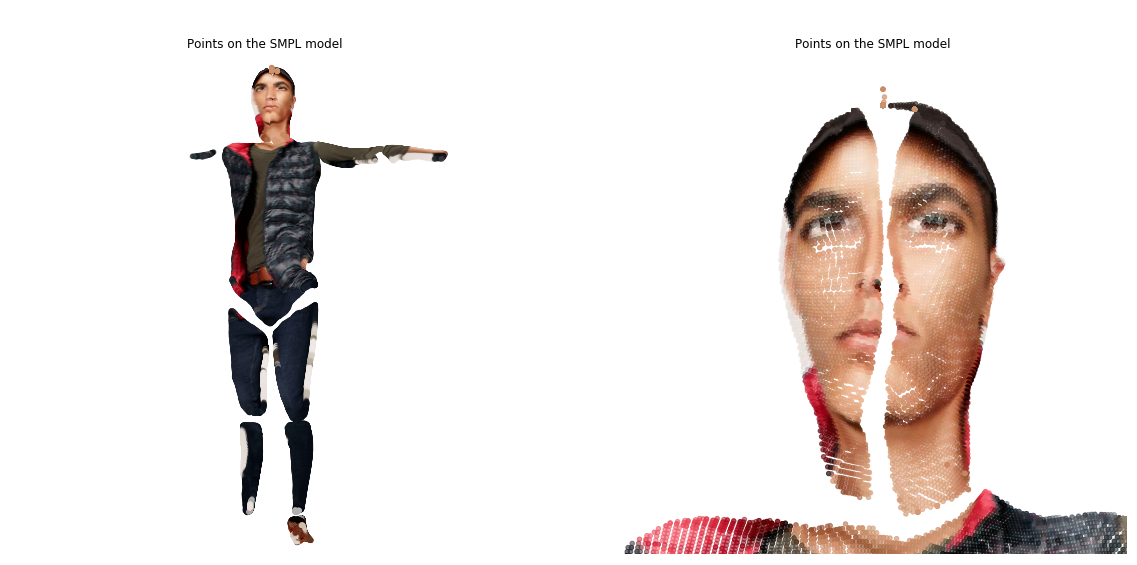

In [11]:
fig = plt.figure(figsize=[20,10])

## Visualize the full body smpl male template model and collected points
ax = fig.add_subplot(121, projection='3d')
# ax.scatter(Z,X,Y,s=0.02,c='k')
ax.scatter(collected_z,  collected_x,collected_y,  c= person_color/255.0   )  #s=__ size
smpl_view_set_axis_full_body(ax)
plt.title('Points on the SMPL model')

## Now zoom into the face.
ax = fig.add_subplot(122, projection='3d')
# ax.scatter(Z,X,Y,s=0.2,c='k')
ax.scatter(collected_z,  collected_x,collected_y,c=person_color/255.0) #s=__ size
smpl_view_set_axis_face(ax)
plt.title('Points on the SMPL model')
#
plt.show()

Let's visualize coverage on the SMPL model.

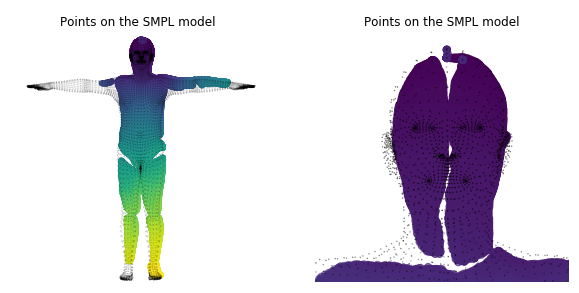

In [59]:
fig = plt.figure(figsize=[10,5])

## Visualize the full body smpl male template model and collected points
ax = fig.add_subplot(121, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
ax.scatter(collected_z,  collected_x,collected_y,s=25,  c=  np.arange(IUV_pick.shape[0])    )
smpl_view_set_axis_full_body(ax)
plt.title('Points on the SMPL model')

## Now zoom into the face.
ax = fig.add_subplot(122, projection='3d')
ax.scatter(Z,X,Y,s=0.2,c='k')
ax.scatter(collected_z,  collected_x,collected_y,s=55,c=np.arange(IUV_pick.shape[0]))
smpl_view_set_axis_face(ax)
plt.title('Points on the SMPL model')
#
plt.show()